In [13]:
import pandas as pd

# Step 1: Load files and attach model labels
filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'chatglm3': '2_THUDM_chatglm3-6b-base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []

for model_name, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model_name
    df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# Step 2: Clean data
df_all['gender'] = df_all['gender'].replace({'m': 'male', 'f': 'female'})
df_all = df_all.dropna(subset=['descriptor', 'gender', 'apx_mean'])

# Step 3: Normalize APX per model (Z-score on apx_mean)
df_all['apx_z'] = df_all.groupby('model')['apx_mean'].transform(lambda x: (x - x.mean()) / x.std())

# Step 4: Gender gap per descriptor per model
desc_gap = df_all.groupby(['model', 'descriptor', 'gender'])['apx_z'].mean().reset_index()
pivot_desc = desc_gap.pivot(index=['model', 'descriptor'], columns='gender', values='apx_z').dropna()
pivot_desc['gap'] = pivot_desc['female'] - pivot_desc['male']

# Step 5: Gender gap per axis per model
axis_gap = df_all.groupby(['model', 'axis', 'gender'])['apx_z'].mean().reset_index()
pivot_axis = axis_gap.pivot(index=['model', 'axis'], columns='gender', values='apx_z').dropna()
pivot_axis['gap'] = pivot_axis['female'] - pivot_axis['male']

# Step 6: Add model type for grouped analysis
model_type_map = {
    'llama3': 'multilingual',
    'xglm': 'multilingual',
    'chatglm3': 'chinese',
    'cpm': 'chinese'
}

df_all['model_type'] = df_all['model'].map(model_type_map)


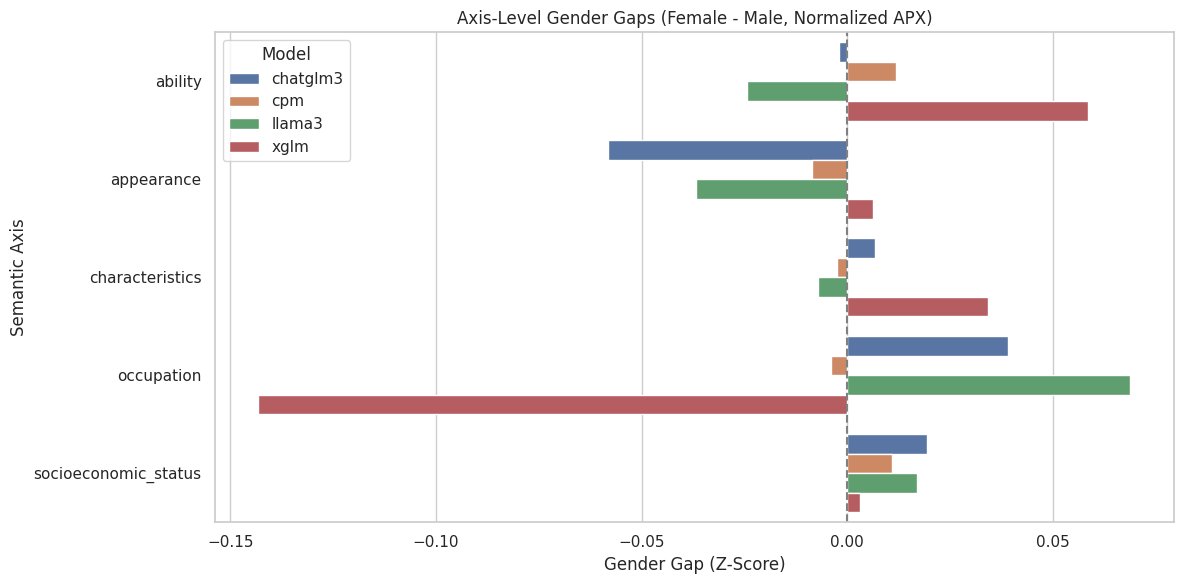

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Prepare the data
axis_gap = df_all.groupby(['model', 'axis', 'gender'])['apx_z'].mean().reset_index()
pivot_axis = axis_gap.pivot(index=['model', 'axis'], columns='gender', values='apx_z').dropna()
pivot_axis['gap'] = pivot_axis['female'] - pivot_axis['male']
pivot_axis = pivot_axis.reset_index()

# Plot barplot of axis-level gaps for each model
plt.figure(figsize=(12, 6))
sns.barplot(data=pivot_axis, x='gap', y='axis', hue='model')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Axis-Level Gender Gaps (Female - Male, Normalized APX)')
plt.xlabel('Gender Gap (Z-Score)')
plt.ylabel('Semantic Axis')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


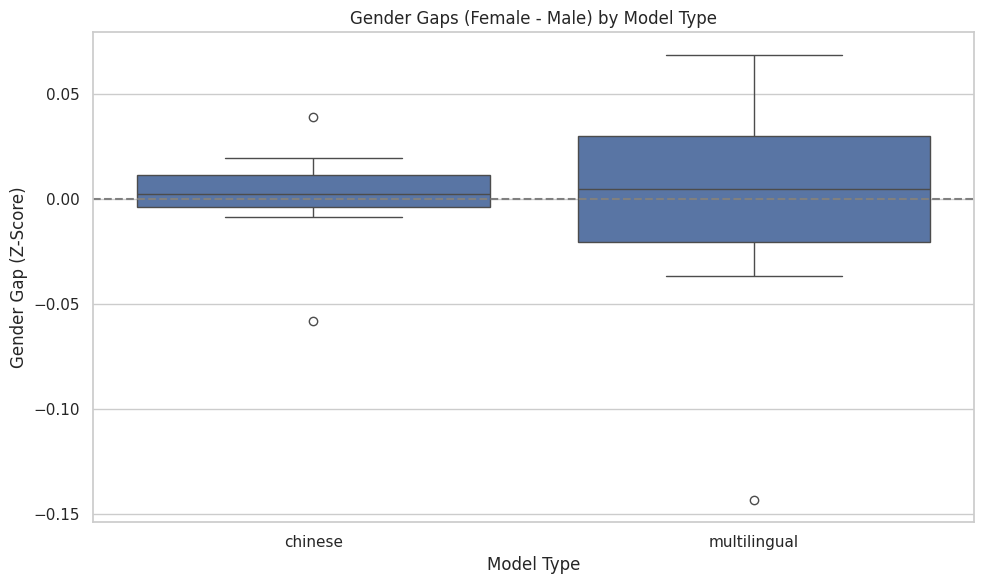

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Recompute axis-level gap and merge model type
axis_gap = df_all.groupby(['model', 'model_type', 'axis', 'gender'])['apx_z'].mean().reset_index()
pivot_axis = axis_gap.pivot(index=['model', 'model_type', 'axis'], columns='gender', values='apx_z').dropna()
pivot_axis['gap'] = pivot_axis['female'] - pivot_axis['male']
pivot_axis = pivot_axis.reset_index()

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=pivot_axis, x='model_type', y='gap')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Gender Gaps (Female - Male) by Model Type')
plt.xlabel('Model Type')
plt.ylabel('Gender Gap (Z-Score)')
plt.tight_layout()
plt.show()


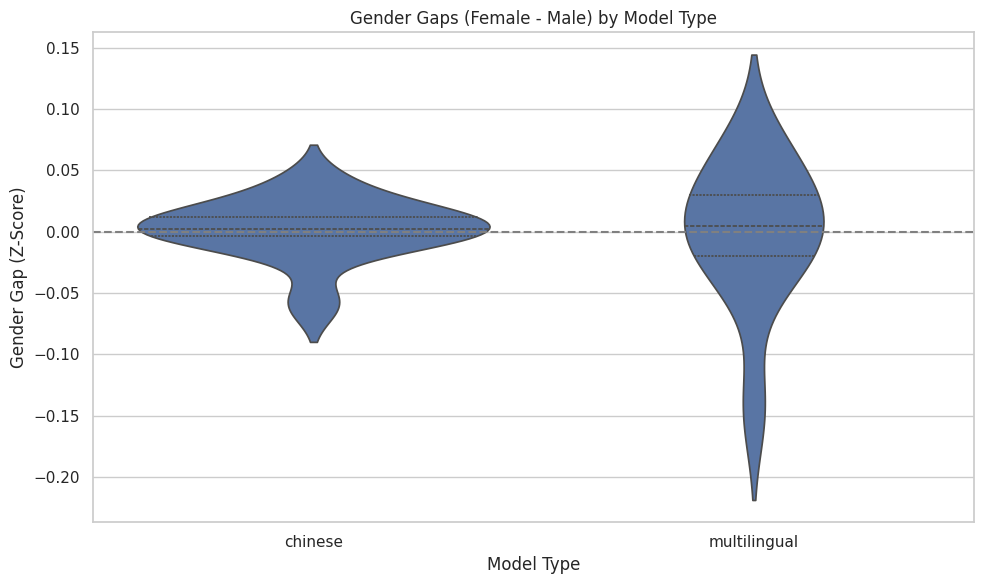

In [16]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=pivot_axis, x='model_type', y='gap', inner='quartile')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Gender Gaps (Female - Male) by Model Type')
plt.xlabel('Model Type')
plt.ylabel('Gender Gap (Z-Score)')
plt.tight_layout()
plt.show()
